<a href="https://colab.research.google.com/github/ling-lyanna-zhang/reserve-neural-policy/blob/main/reserve_118bus_(step1)benchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [231]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [232]:
# in case gpu is used
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [233]:
import os, time
import cvxpy as cp
import random
from numpy import savetxt
import argparse
import json
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable

root_path = './gdrive/MyDrive/Inbox/rs_neural_policy/'


In [234]:
# nn.init.trunc_normal__(tensor: Tensor, 
#                        mean: float = 0., 
#                        std: float = 1., 
#                        a: float = -2., 
#                        b: float = 2.)

In [235]:
# Install MOSEK if not already installed
!pip install mosek

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [236]:
print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


# helper functions, can be folded

## utils.py

In [237]:
def create_dir(PATH):
    isExist = os.path.exists(PATH)

    if not isExist:
        # Create a new directory if it does not exist 
        os.makedirs(PATH)
        print("The new directory is created!")


# Evaluate using vector distance
def measure_relative_distance(v1, v2):
    '''
        Note that v1 is the benchmark.
        Norm is calculated along dimension/axis 1
        and average is calculated along dimension/axis 0
        Also return the distance vetor.
    '''
    if len(v1.shape)==1 and len(v2.shape)==1:
        distance = np.abs(v1-v2)/np.abs(v1)

    if len(v1.shape)==2 and len(v2.shape)==2:
        distance = np.linalg.norm(v1-v2, axis=1)/np.linalg.norm(v1, axis=1)

    return distance, np.mean(distance)

## paths.py

In [238]:
def get_paths():
    params_path = root_path+'118bus/params/'
    data_path = root_path+'118bus/data/'
    model_path = root_path+'118bus/saved_models_cnn/'
    saved_path = root_path+'118bus/predictions_cnn/'


    isExist = os.path.exists(data_path)
    if not isExist:
        # Create a new directory if it does not exist 
        os.makedirs(data_path)

    isExist = os.path.exists(model_path)
    if not isExist:
        # Create a new directory if it does not exist 
        os.makedirs(model_path)

    
    isExist = os.path.exists(saved_path)
    if not isExist:
        # Create a new directory if it does not exist 
        os.makedirs(saved_path)

    return params_path, data_path, saved_path, model_path

In [239]:
def load_cost_coeff(params_path):    
    quad_cost_coeff = np.load(params_path+'quad_cost_coeff.npy')
    linear_cost_coeff = np.load(params_path+'linear_cost_coeff.npy')
    da_cost_coeff = np.load(params_path+'da_cost_coeff.npy')

    return quad_cost_coeff, linear_cost_coeff, da_cost_coeff


## system.py

In [240]:
def identify_unique_lines(connections):
    all_lines = {}
    count = 0
    for line in connections:
        all_lines[count] = line
        count+=1

    # This code snippet only finds out the repeated lines with exactly the same order of nodes,
    # but not deal with that [i,j] and [j,i] are also repeated lines
    # By checking connections, there is no repeated lines like [i,j] and [j,i]
    unique_lines = {}
    for k, val in all_lines.items():
        if val not in unique_lines.values():
            unique_lines[k]=val
    print('unique_lines length:', len(unique_lines))

    repeated_lines = [[42, 49],[49, 54],[56, 59],[49, 66],[77, 80],[89, 90],[89, 92]]
    # For example, [42, 49] appears twice
    set1 = {}
    set2 = {}
    for k, val in all_lines.items():
        if val in repeated_lines and k in unique_lines:
            set1[val[0], val[1]] = k # Record the repeated lines when they first appear
        if val in repeated_lines and k not in unique_lines:
            set2[val[0], val[1]] = k # Record the repeated lines when they appear more than once

    # print('set1:', len(set1))
    # print('set2:', len(set2))

    return unique_lines, set1, set2


def get_Y(N, B):
    # N = num_buses
    Y = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i==j : 
                Y[i,j] = sum(B[i,:])
            else: 
                Y[i,j] = -B[i,j]

    return Y[:,1:]


def get_A(N, L, B, connections):
    # N = num_buses
    # L = num_lines 
    A = np.zeros((L, N))

    for i, line in enumerate(connections):
        row = line[0]-1
        col = line[1]-1
        A[i, row] = B[row,col]
        A[i, col] = -B[row,col]

    return A[:,1:]


# Import 118bus
def import_118bus(params_path):
    bus_data_fname = '118bus_BusData.csv'
    gen_data_fname = '118bus_GenData.csv'
    branch_data_fname = '118bus_BranchData.csv'
    cost_data_fname = '118bus_CostData.csv'

    bus_data_df = pd.read_csv(params_path+bus_data_fname,header=None)
    gen_data_df = pd.read_csv(params_path+gen_data_fname,header=None)
    branch_data_df = pd.read_csv(params_path+branch_data_fname,header=None)
    cost_data_df = pd.read_csv(params_path+cost_data_fname,header=None)


    num_buses = bus_data_df.shape[0]
    num_lines = branch_data_df.shape[0]
    num_gens = gen_data_df.shape[0]


    bus_data = bus_data_df.to_numpy()
    gen_data = gen_data_df.to_numpy()
    branch_data = branch_data_df.to_numpy()
    cost_data = cost_data_df.to_numpy()

    x = branch_data[:,3]
    print('max of x:', max(x))
    print('min of x:', min(x))


    b = 1/x
    Z0 = 10
    b = b/Z0
    print('max of b:', max(b))
    print('min of b:', min(b))

    connections = []
    branches = branch_data[:,:2]
    for i in range(branches.shape[0]):
            connections.append([int(branches[i,0]),int(branches[i,1])])
    print('len of connections:', len(connections))

    unique_lines, set1, set2 = identify_unique_lines(connections)

    B = np.zeros((num_buses, num_buses))
    for k, line in unique_lines.items():
        row = line[0]-1
        col = line[1]-1
        B[row, col] = b[k]
        B[col, row] = b[k]

    PD = bus_data[:,2]/20
    print('Total PD:', sum(PD))

    return num_buses, num_lines, B, connections, PD

### import B, F and cost

In [241]:
params_path, data_path, saved_path, model_path = get_paths()

num_buses, num_lines, B, connections, PD_data = import_118bus(params_path)

N = num_buses
L = num_lines 

Yrr = get_Y(num_buses, B)
Arr = get_A(num_buses, num_lines, B, connections)

# Load cost coefficients
quad_cost_coeff, linear_cost_coeff, da_cost_coeff = load_cost_coeff(params_path) 

quad_cost_Coeff = np.diag(quad_cost_coeff)
linear_cost_Coeff = linear_cost_coeff.reshape(-1, 1)
da_cost_Coeff = da_cost_coeff.reshape(-1,1)

print('quad_cost_Coeff shape:', quad_cost_Coeff.shape)
print('linear_cost_Coeff shape:', linear_cost_Coeff.shape)
print('da_cost_Coeff shape:', da_cost_Coeff.shape)

c = da_cost_Coeff
q = linear_cost_Coeff

max of x: 0.411
min of x: 0.004
max of b: 25.0
min of b: 0.24330900243309003
len of connections: 186
unique_lines length: 179
Total PD: 212.10000000000005
quad_cost_Coeff shape: (118, 118)
linear_cost_Coeff shape: (118, 1)
da_cost_Coeff shape: (118, 1)


### set Pmax/Pmin, Fmax and std

In [242]:
DayAheadReserveCostFactor = 1.1
RecourseReserveCostFactor = 5.
Pmax = 20.
Pmin = 0.
Fmax = 15.

input_std = 0.1
sce_std = 0.05

## dataloader.py

In [243]:
def generate_inputs(Ntr, Ntst, Ntr2, scaling, nominal_PD_data, data_path):


    forecast = nominal_PD_data.flatten()

    std_vec = forecast*scaling
    std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

    train_dataset = np.random.multivariate_normal(forecast, np.diag(std_vec), Ntr)
    train_dataset = np.clip(train_dataset, a_min=0., a_max=None)

    test_dataset = np.random.multivariate_normal(forecast, np.diag(std_vec), Ntst)
    test_dataset = np.clip(test_dataset, a_min=0., a_max=None)

    # Generate dataset for pretrain
    random_rows = np.random.choice(Ntr, Ntr2)
    pretrain_dataset = train_dataset[random_rows,:]
    print('pretrain_dataset:', pretrain_dataset.shape)

    np.save(data_path+'train_set.npy', train_dataset)
    np.save(data_path+'test_set.npy', test_dataset)
    np.save(data_path+'pretrain_set.npy', pretrain_dataset)

    return train_dataset, test_dataset, pretrain_dataset

In [244]:
def for_sinlge_instance(forecast, x):

    p0 = x[:N,:]
    r_up = x[N:N+N,:]
    r_down = x[N+N:,:]

    theta = cp.Variable((N-1,1))
    y = cp.Variable((N, 1))

    constraints_list = []

    PD = forecast.flatten()
    std_vec = PD*sce_std
    std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

    rt_scenario = np.random.multivariate_normal(PD, np.diag(std_vec), 1)
    # generated scenario are arranged in rows, must be transposed
    rt_scenario = np.clip(rt_scenario, a_min=0., a_max=None).T
    assert rt_scenario.shape[0] == N
    
    net_d_omega = rt_scenario - p0

    constraints_list.append( y == Yrr@theta + net_d_omega )

    constraints_list.append( p0 + y <= Pmax*np.ones((N, 1)))
    constraints_list.append( p0 + y >= Pmin*np.ones((N, 1)))
    # constraints_list.append( y <= r_up)
    # constraints_list.append( y >= -r_down)
        
    constraints_list.append( Arr@theta <= Fmax*np.ones((num_lines, 1)))
    constraints_list.append( Arr@theta >= -Fmax*np.ones((num_lines, 1)))

    constraints_list.append( theta<=np.pi)
    constraints_list.append( theta>=-np.pi)

    recourse_cost = cp.abs(y).T@q +\
        cp.pos(y-r_up).T@q*RecourseReserveCostFactor +\
        cp.pos(y+r_down).T@q*RecourseReserveCostFactor

    Q_pred = recourse_cost

    prob = cp.Problem(cp.Minimize( Q_pred ), constraints_list)

    # prob.solve(verbose = False, solver = cp.ECOS) ## Works!   
    prob.solve(verbose = False, solver = cp.CVXOPT) ## Works! 

    return prob.value, y.value, theta.value, net_d_omega, prob.status

In [245]:
def solve_stochastic_dcopf(forecasts, x_vals):
    '''
    Given a single instance and the initial dispatch x, and evaluate the quality
    of x.
    This function can be applied to the decision obtained from any policy.
    '''
    num_points = forecasts.shape[0]

    Q_vals = []
    y_vals = []
    theta_vals = []
    net_d_vals = []
    for i in range(num_points):
        forecast = forecasts[i,:].reshape(-1,1)
        x = x_vals[i,:].reshape(-1,1)

        Q_omega, y_omega, theta_omega, net_d_omega, prob_status = for_sinlge_instance(forecast, x)

        if prob_status in ["infeasible", "unbounded"]:
            print("Problem is " + str(prob_status))
            Q_omega = 0.
            y_omega = np.zeros((N, 1))
            theta_omega = np.zeros((N-1, 1))

        Q_vals.append(Q_omega)
        y_vals.append(y_omega.flatten())
        theta_vals.append(theta_omega.flatten())
        net_d_vals.append(net_d_omega.flatten())

    Q_vals = np.array(Q_vals).reshape(-1,1)
    y_vals = np.array(y_vals)
    theta_vals = np.array(theta_vals)
    net_d_vals = np.array(net_d_vals)

    return Q_vals, y_vals, theta_vals, net_d_vals


## benchmarks.py

### solver

In [246]:
def solve_GAP(forecast, num_sce):
    '''
    Implemented by following the GAP model in [Kannan, Luedtke, Roald(2020)].
    I think it is kind of weird that y doesn't have an offset and the second-stage
    is totally determined by the uncertainties.
    So implement modified GAP instead.
    '''

    M = num_sce

    # c = da_cost_Coeff
    # q = linear_cost_Coeff
    B = -Yrr
    F = Arr
    rho_lb = 10.
    rho_ub = 10.
    gamma_lb = 10.
    gamma_ub = 10.
    ones = np.ones((N,1))

    Brr = -Yrr[1:,:]
    Brr_inv = np.linalg.inv(Brr)
    I = np.eye(N)
    R = I[1:,:]
    
    # first-stage decision variables
    x = cp.Variable((N, 1))
    r_up = cp.Variable((N, 1))
    r_down = cp.Variable((N, 1))
    alpha = cp.Variable((N, 1))

    # no second-stage decision variables
    # beta = cp.Variable((N,1))

    # theta = cp.Variable((N-1,M))

    constraints_list = []

    Q_vals = []

    # generate M uncertainty realizations
    PD = forecast.flatten()
    std_vec = PD*sce_std
    std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

    scenarios = np.random.multivariate_normal(PD, np.diag(std_vec), M)
    scenarios = np.clip(scenarios, a_min=0., a_max=None).T
    assert scenarios.shape[0] == N

    for m in range(M):
        # for each scenario of noise
        omega =  scenarios[:, m:m+1] - forecast
        net_d = scenarios[:, m:m+1] - x

        # y_pred = (ones.T@omega)*alpha + beta
        y_pred = (ones.T@omega)*alpha
        theta_pred = Brr_inv@R@(net_d-y_pred)

        constraints_list.append( y_pred == Yrr@theta_pred + net_d )

        p_f_lb = rho_lb*cp.square( cp.norm( cp.pos(-Fmax*np.ones((num_lines, 1)) - F@theta_pred) ) )
        p_f_ub = rho_ub*cp.square( cp.norm(  cp.pos(F@theta_pred -Fmax*np.ones((num_lines, 1))) ) )

        p_theta_lb  = rho_lb*cp.square( cp.norm(  cp.pos(-np.pi*np.ones((N-1, 1)) - theta_pred) ) )
        p_theta_ub  = rho_ub*cp.square( cp.norm(  cp.pos(theta_pred - np.pi*np.ones((N-1, 1))) ) )

        p_y_ub  = gamma_lb*cp.square( cp.norm( cp.pos(x+y_pred-Pmax*np.ones((N, 1))) ))
        p_y_lb  = gamma_ub*cp.square( cp.norm( cp.pos(Pmin*np.ones((N, 1))-(x+y_pred) ) ))

        recourse_cost = cp.abs(y_pred).T@q +\
                cp.pos(y_pred-r_up).T@q*RecourseReserveCostFactor +\
                cp.pos(y_pred+r_down).T@q*RecourseReserveCostFactor

        Q_val = recourse_cost + p_f_lb + p_f_ub + p_theta_lb + p_theta_ub
        Q_val += p_y_ub + p_y_lb

        Q_vals.append(Q_val)

    constraints_list.append( ones.T@x== ones.T@forecast)
    constraints_list.append( x+r_up <= Pmax*np.ones((N, 1)))
    constraints_list.append( x-r_down >= Pmin*np.ones((N, 1)))
    constraints_list.append( x>=Pmin)
    constraints_list.append( x<=Pmax)
    constraints_list.append( r_up>=0)
    constraints_list.append( r_down>=0)
    constraints_list.append( ones.T@alpha==1)
    constraints_list.append( alpha>=0)

    Q_pred = cp.sum(Q_vals)/M

    da_cost = c.T@x + DayAheadReserveCostFactor*c.T@(r_up+r_down)

    prob = cp.Problem(cp.Minimize( da_cost + Q_pred ), constraints_list)

    # prob.solve(verbose = False, solver = cp.ECOS) ## Works!  
    prob.solve(verbose = False, solver = cp.CVXOPT) ## Works!  

    solutions = np.concatenate([x.value.T, r_up.value.T, r_down.value.T], axis=-1)


    return solutions, prob.value, prob.status

In [247]:
def solve_modified_GAP(forecast, num_sce):
    '''
    Implemented by following the GAP model in [Kannan, Luedtke, Roald(2020)].
    I think it is kind of weird that y doesn't have an offset and the second-stage
    is totally determined by the uncertainties.
    So implement modified GAP instead.
    '''

    M = num_sce

    # c = da_cost_Coeff
    # q = linear_cost_Coeff
    B = -Yrr
    F = Arr
    rho_lb = 10.
    rho_ub = 10.
    gamma_lb = 10.
    gamma_ub = 10.
    ones = np.ones((N,1))

    Brr = -Yrr[1:,:]
    Brr_inv = np.linalg.inv(Brr)
    I = np.eye(N)
    R = I[1:,:]
    
    # first-stage decision variables
    x = cp.Variable((N, 1))
    r_up = cp.Variable((N, 1))
    r_down = cp.Variable((N, 1))
    alpha = cp.Variable((N, 1))

    # second-stage decision variables
    beta = cp.Variable((N,1))


    constraints_list = []
    Q_vals = []

    PD = forecast.flatten()
    std_vec = PD*sce_std
    std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

    # generate M uncertainty realizations using the given forecast as mean
    # vector and 5% of it as std.
    scenarios = np.random.multivariate_normal(PD, np.diag(std_vec), M)
    scenarios = np.clip(scenarios, a_min=0., a_max=None).T
    assert scenarios.shape[0] == N

    for m in range(M):
        # for each scenario of noise
        omega =  scenarios[:, m:m+1] - forecast
        net_d = scenarios[:, m:m+1] - x

        y_pred = (ones.T@omega)*alpha + beta
        theta_pred = Brr_inv@R@(net_d-y_pred)

        constraints_list.append( y_pred == Yrr@theta_pred + net_d )

        p_f_lb = rho_lb*cp.square( cp.norm( cp.pos(-Fmax*np.ones((num_lines, 1)) - F@theta_pred) ) )
        p_f_ub = rho_ub*cp.square( cp.norm(  cp.pos(F@theta_pred -Fmax*np.ones((num_lines, 1))) ) )

        p_theta_lb  = rho_lb*cp.square( cp.norm(  cp.pos(-np.pi*np.ones((N-1, 1)) - theta_pred) ) )
        p_theta_ub  = rho_ub*cp.square( cp.norm(  cp.pos(theta_pred - np.pi*np.ones((N-1, 1))) ) )

        p_y_ub  = gamma_lb*cp.square( cp.norm( cp.pos(x+y_pred-Pmax*np.ones((N, 1))) ))
        p_y_lb  = gamma_ub*cp.square( cp.norm( cp.pos(Pmin*np.ones((N, 1))-(x+y_pred) ) ))

        recourse_cost = cp.abs(y_pred).T@q +\
                cp.pos(y_pred-r_up).T@q*RecourseReserveCostFactor +\
                cp.pos(y_pred+r_down).T@q*RecourseReserveCostFactor

        Q_val = recourse_cost + p_f_lb + p_f_ub + p_theta_lb + p_theta_ub
        Q_val += p_y_ub + p_y_lb

        Q_vals.append(Q_val)

    constraints_list.append( ones.T@x== ones.T@forecast)
    constraints_list.append( x+r_up <= Pmax*np.ones((N, 1)))
    constraints_list.append( x-r_down >= Pmin*np.ones((N, 1)))
    constraints_list.append( x>=Pmin)
    constraints_list.append( x<=Pmax)
    constraints_list.append( r_up>=0)
    constraints_list.append( r_down>=0)
    constraints_list.append( ones.T@alpha==1)
    constraints_list.append( alpha>=0)

    Q_pred = cp.sum(Q_vals)/M

    da_cost = c.T@x + DayAheadReserveCostFactor*c.T@(r_up+r_down)

    prob = cp.Problem(cp.Minimize( da_cost + Q_pred ), constraints_list)

    # prob.solve(verbose = False, solver = cp.ECOS) ## Works!  
    prob.solve(verbose = False, solver = cp.CVXOPT) ## Works! 

    solutions = np.concatenate([x.value.T, r_up.value.T, r_down.value.T], axis=-1)


    return solutions, prob.value, prob.status

In [248]:
def solve_AP(forecast, num_sce):
    '''
    This solver more flexible, only assume y is affine in total imbalance, and do not
    enforce the coefficients summing up to 1. both alpha and beta are determined after observing 
    uncertainty realizations.
    '''

    M = num_sce

    # c = da_cost_Coeff
    # q = linear_cost_Coeff
    B = -Yrr
    F = Arr
    rho_lb = 10.
    rho_ub = 10.
    gamma_lb = 10.
    gamma_ub = 10.
    ones = np.ones((N,1))

    Brr = -Yrr[1:,:]
    Brr_inv = np.linalg.inv(Brr)
    I = np.eye(N)
    R = I[1:,:]
    
    # first-stage decision variables
    x = cp.Variable((N, 1))
    r_up = cp.Variable((N, 1))
    r_down = cp.Variable((N, 1))
    
    # second-stage decision variables
    alpha = cp.Variable((N, 1))
    beta = cp.Variable((N,1))


    constraints_list = []
    Q_vals = []

    PD = forecast.flatten()
    std_vec = PD*sce_std
    std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

    # generate M uncertainty realizations using the given forecast as mean
    # vector and 5% of it as std.
    scenarios = np.random.multivariate_normal(PD, np.diag(std_vec), M)
    scenarios = np.clip(scenarios, a_min=0., a_max=None).T
    assert scenarios.shape[0] == N

    for m in range(M):
        # for each scenario of noise
        omega =  scenarios[:, m:m+1] - forecast
        net_d = scenarios[:, m:m+1] - x

        y_pred = (ones.T@omega)*alpha + beta
        theta_pred = Brr_inv@R@(net_d-y_pred)

        constraints_list.append( y_pred == Yrr@theta_pred + net_d )

        p_f_lb = rho_lb*cp.square( cp.norm( cp.pos(-Fmax*np.ones((num_lines, 1)) - F@theta_pred) ) )
        p_f_ub = rho_ub*cp.square( cp.norm(  cp.pos(F@theta_pred -Fmax*np.ones((num_lines, 1))) ) )

        p_theta_lb  = rho_lb*cp.square( cp.norm(  cp.pos(-np.pi*np.ones((N-1, 1)) - theta_pred) ) )
        p_theta_ub  = rho_ub*cp.square( cp.norm(  cp.pos(theta_pred - np.pi*np.ones((N-1, 1))) ) )

        p_y_ub  = gamma_lb*cp.square( cp.norm( cp.pos(x+y_pred-Pmax*np.ones((N, 1))) ))
        p_y_lb  = gamma_ub*cp.square( cp.norm( cp.pos(Pmin*np.ones((N, 1))-(x+y_pred) ) ))

        recourse_cost = cp.abs(y_pred).T@q +\
                cp.pos(y_pred-r_up).T@q*RecourseReserveCostFactor +\
                cp.pos(y_pred+r_down).T@q*RecourseReserveCostFactor

        Q_val = recourse_cost + p_f_lb + p_f_ub + p_theta_lb + p_theta_ub
        Q_val += p_y_ub + p_y_lb

        Q_vals.append(Q_val)

    constraints_list.append( ones.T@x== ones.T@forecast)
    constraints_list.append( x+r_up <= Pmax*np.ones((N, 1)))
    constraints_list.append( x-r_down >= Pmin*np.ones((N, 1)))
    constraints_list.append( x>=Pmin)
    constraints_list.append( x<=Pmax)
    constraints_list.append( r_up>=0)
    constraints_list.append( r_down>=0)

    Q_pred = cp.sum(Q_vals)/M

    da_cost = c.T@x + DayAheadReserveCostFactor*c.T@(r_up+r_down)

    prob = cp.Problem(cp.Minimize( da_cost + Q_pred ), constraints_list)

    # prob.solve(verbose = False, solver = cp.ECOS) ## Works!  
    prob.solve(verbose = False, solver = cp.CVXOPT) ## Works! 

    solutions = np.concatenate([x.value.T, r_up.value.T, r_down.value.T], axis=-1)


    return solutions, prob.value, prob.status

In [249]:
def solve_SAA(forecast, num_sce):
    '''
    Given a single instance of forecast, solve the SAA version
    of the true problem.
    This is called cp policy in our work.
    '''

    M = num_sce
    ones = np.ones((N,1))

    x = cp.Variable((N, 1))
    r_up = cp.Variable((N, 1))
    r_down = cp.Variable((N, 1))
    theta = cp.Variable((N-1,M))
    y = cp.Variable((N, M))

    constraints_list = []

    PD = forecast.flatten()
    std_vec = PD*sce_std
    std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

    scenarios = np.random.multivariate_normal(PD, np.diag(std_vec), M)
    scenarios = np.clip(scenarios, a_min=0., a_max=None).T
    assert scenarios.shape[0] == N

    for m in range(M):

        net_d = scenarios[:, m:m+1] - x

        constraints_list.append( y[:,m:m+1] == Yrr@theta[:,m:m+1] + net_d )

        constraints_list.append( x+y[:,m:m+1]<=Pmax*np.ones((N, 1)))
        constraints_list.append( x+y[:,m:m+1]>=Pmin*np.ones((N, 1)))
        # constraints_list.append( ones.T@y[:,m:m+1]<=ones.T@r_up)
        # constraints_list.append( ones.T@y[:,m:m+1]>=-ones.T@r_down)
            
    constraints_list.append( Arr@theta <= Fmax*np.ones((num_lines, M)))
    constraints_list.append( Arr@theta >= -Fmax*np.ones((num_lines, M)))

    constraints_list.append( theta<=np.pi)
    constraints_list.append( theta>=-np.pi)
    
    constraints_list.append( ones.T@x== ones.T@forecast)
    constraints_list.append( x+r_up <= Pmax*np.ones((N, 1)))
    constraints_list.append( x-r_down >= Pmin*np.ones((N, 1)))
    constraints_list.append( x>=Pmin)
    constraints_list.append( x<=Pmax)
    constraints_list.append( r_up>=0)
    constraints_list.append( r_down>=0)

    Q_vals = []
    for m in range(M):

        # total_cost += cp.quad_form(y[:,m:m+1], quad_cost_Coeff) + y[:,m:m+1].T@linear_cost_Coeff
        recourse_cost = cp.abs(y[:,m:m+1]).T@q +\
                        cp.pos(y[:,m:m+1]-r_up).T@q*RecourseReserveCostFactor +\
                        cp.pos(y[:,m:m+1]+r_down).T@q*RecourseReserveCostFactor
        Q_vals.append(recourse_cost)

    Q_pred = cp.sum(Q_vals)/M
    da_cost = c.T@x + DayAheadReserveCostFactor*c.T@(r_up+r_down)
    prob = cp.Problem(cp.Minimize( da_cost + Q_pred ), constraints_list)
   
    # prob.solve(verbose = False, solver = cp.ECOS) ## Works! 
    # prob.solve(verbose = False, solver = cp.MOSEK) ## Works!
    # prob.solve(verbose = False, solver = cp.SCS) ## Works!
    prob.solve(verbose = False, solver = cp.CVXOPT) ## Works! 
    # if prob.status in ["infeasible", "unbounded"]:
    #     print("Problem is " + str(prob.status))

    solutions = np.concatenate([x.value.T, r_up.value.T, r_down.value.T], axis=-1)


    return solutions, prob.value, prob.status


def solver_outer_loop(forecasts, num_sce, solver_name):
    '''
    Given a batch of instances and solve rld problem for each instance.
    We only care about x for now.
    Can return computation time for each instance at the same time (in minutes)
    '''

    num_points = forecasts.shape[0]

    x_vals = []
    total_cost_vals = []
    times = []


    for it in range(num_points):

        forecast = forecasts[it,:].reshape(-1,1)

        start_time = time.time()

        if solver_name == 'saa':
            x_value, prob_value, prob_status = solve_SAA(forecast, num_sce)

        elif solver_name == 'ap':
            x_value, prob_value, prob_status = solve_AP(forecast, num_sce)

        elif solver_name == 'modified_gap':
            x_value, prob_value, prob_status = solve_modified_GAP(forecast, num_sce)

        elif solver_name == 'gap':
            x_value, prob_value, prob_status = solve_GAP(forecast, num_sce)

        # elif solver_name == 'pwa':
        #     x_value, prob_value, prob_status = solve_PWA(forecast, num_sce)

        else:
            print('No such solver exists!')

        if prob_status in ["infeasible", "unbounded"]:
            print("Problem is " + str(prob_status))
            x_value = np.inf*np.ones((N, 1))
            prob_value = np.inf

        end_time = time.time()
        times.append((end_time-start_time)/60)

        x_vals.append(x_value.flatten())
        total_cost_vals.append(prob_value)

        # print("--- %s minutes ---" % ((time.time() - start_time)/60))
        
    x_vals = np.array(x_vals)
    total_cost_vals = np.array(total_cost_vals).reshape(-1,1)
    times = np.array(times)

    return x_vals, total_cost_vals, times


### evaluate policy

In [250]:
def evaluate_Q(forecast, x, num_sce):
    '''
    Given a single instance and the initial dispatch x, and evaluate the quality
    of x.
    This function can be applied to the decision obtained from any policy.
    '''

    M = num_sce 
    ones = np.ones((N,1))

    p0 = x[:N,:]
    r_up = x[N:N+N,:]
    r_down = x[N+N:,:]

    theta = cp.Variable((N-1,M))
    y = cp.Variable((N, M))


    net_d_vals = np.zeros((N, M))

    constraints_list = []

    PD = forecast.flatten()
    std_vec = PD*sce_std
    std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

    scenarios = np.random.multivariate_normal(PD, np.diag(std_vec), M)
    scenarios = np.clip(scenarios, a_min=0., a_max=None).T
    assert scenarios.shape[0] == N

    for m in range(M):
        net_d = scenarios[:, m:m+1] - p0
        
        # net_d_vals[:,m:m+1] = net_d

        constraints_list.append( y[:,m:m+1] == Yrr@theta[:,m:m+1] + net_d )
        constraints_list.append( p0 + y[:,m:m+1]<=Pmax*np.ones((N, 1)))
        constraints_list.append( p0 + y[:,m:m+1]>=Pmin*np.ones((N, 1)))
        # constraints_list.append( ones.T@y[:,m:m+1]<=ones.T@r_up)
        # constraints_list.append( ones.T@y[:,m:m+1]>=-ones.T@r_down)
        
    constraints_list.append( Arr@theta <= Fmax*np.ones((num_lines, M)))
    constraints_list.append( Arr@theta >= -Fmax*np.ones((num_lines, M)))

    constraints_list.append( theta<=np.pi)
    constraints_list.append( theta>=-np.pi)

    Q_vals = []
    for m in range(M):
        recourse_cost = cp.abs(y[:,m:m+1]).T@q+\
                cp.pos(y[:,m:m+1]-r_up).T@q*RecourseReserveCostFactor +\
                cp.pos(y[:,m:m+1]+r_down).T@q*RecourseReserveCostFactor 

        Q_vals.append(recourse_cost)

    Q_pred = cp.sum(Q_vals)/M

    prob = cp.Problem(cp.Minimize( Q_pred ), constraints_list)

    # prob.solve(verbose = False, solver = cp.SCS) ## Works!   
    prob.solve(verbose = False, solver = cp.CVXOPT) ## Works! 

    if prob.status in ["infeasible", "unbounded"]:
            return prob.value, np.inf*np.ones((N,1)), prob.status

    return prob.value, np.sum(y.value, axis=1)/M, prob.status


def evaluate_outer_loop(forecasts, x_pred, num_sce):
    '''
    Given a batch of instances and the associated predictions of first stage decision,
    and evaluate these initial dispatch decisions for each instance.

    '''

    num_points = forecasts.shape[0]

    Q_pred = []
    y_pred = []

    for i in range(num_points):
        forecast = forecasts[i,:].reshape(-1,1)
        init_dispatch = x_pred[i,:].reshape(-1,1)

        Q_value, avg_y_value, prob_status = evaluate_Q(forecast, init_dispatch, num_sce)

        if prob_status in ["infeasible", "unbounded"]:
            print("Problem is " + str(prob_status))
            avg_y_value = np.inf*np.ones((N, 1))
            Q_value = np.inf

        Q_pred.append(Q_value)
        y_pred.append(avg_y_value.flatten())
        

    Q_pred = np.array(Q_pred).reshape(-1,1)
    y_pred = np.array(y_pred)

    p0 = x_pred[:,:N]
    r_up = x_pred[:,N:N+N]
    r_down = x_pred[:,N+N:]

    da_cost = (p0+r_up+r_down)@c
    total_cost_pred = (p0+r_up+r_down)@c + Q_pred
    

    return total_cost_pred, Q_pred, y_pred

# Construct datasets

## Construct train_set, test_set, pretrain_set if needed

In [251]:
nominal_PD_data = PD_data.reshape(1,-1)

# Load dataset
Ntr = 50
Ntr2 = 10
Ntst = 10

train_dataset, test_dataset, pretrain_dataset = generate_inputs(Ntr, Ntst, Ntr2,
                                                    input_std, nominal_PD_data, 
                                                    data_path)

# train_dataset = np.load(data_path+'train_set.npy')
# test_dataset = np.load(data_path+'test_set.npy')
# pretrain_dataset = np.load(data_path+'pretrain_set.npy')

print('train set:', train_dataset.shape)
print('test set:', test_dataset.shape)
print('pretrain set:', pretrain_dataset.shape)

pretrain_dataset: (10, 118)
train set: (50, 118)
test set: (10, 118)
pretrain set: (10, 118)


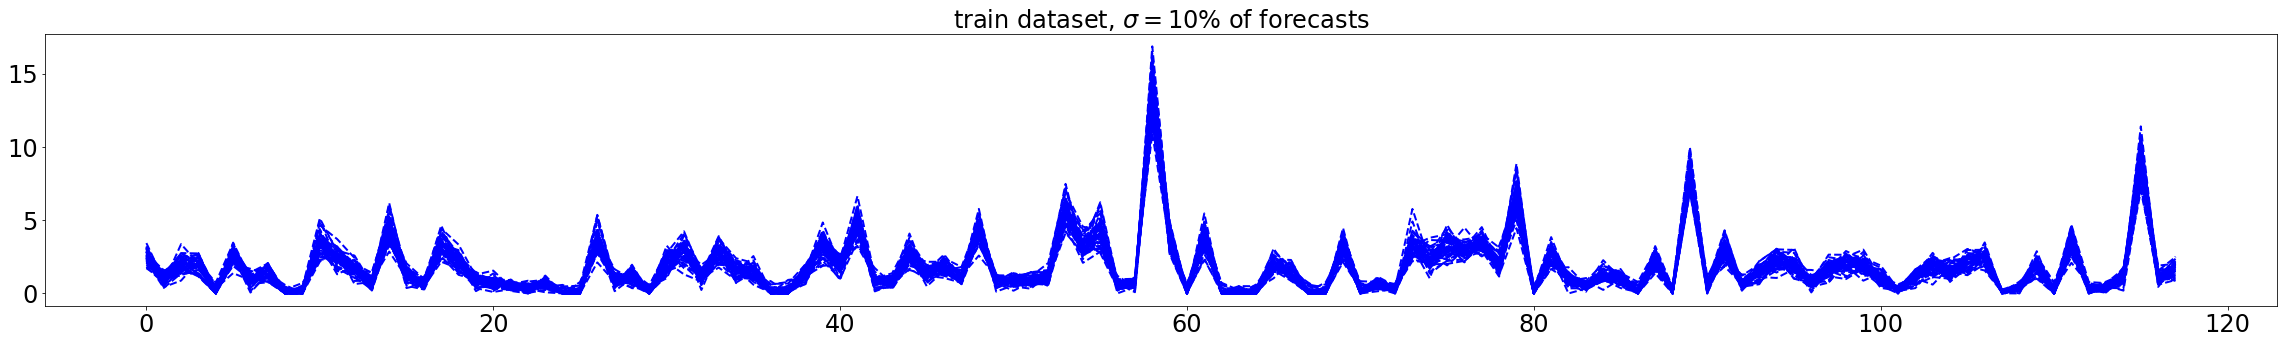

In [252]:
fig, ax0 = plt.subplots(figsize=(40,5))
Xrange = np.array(range(N))
N_points = np.minimum(Ntr, 500)
for i in range(N_points):
    ax0.plot(Xrange, train_dataset[i,:], 'b--', markersize=10, linewidth=2)

# ax0.axhline(y=Pmax, xmin=0.0, xmax=1.0, color='k', linestyle='--', linewidth=1, label='Pmax')
# ax0.legend(fontsize=24)
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )
# ax0.set_xlabel('Buses', fontsize=24 )
# ax0.set_ylabel('total power', fontsize=24 )
ax0.set_title(r'train dataset, $\sigma=$'+str(int(input_std*100))+'% of forecasts', fontsize=24, color='k' )
plt.show()

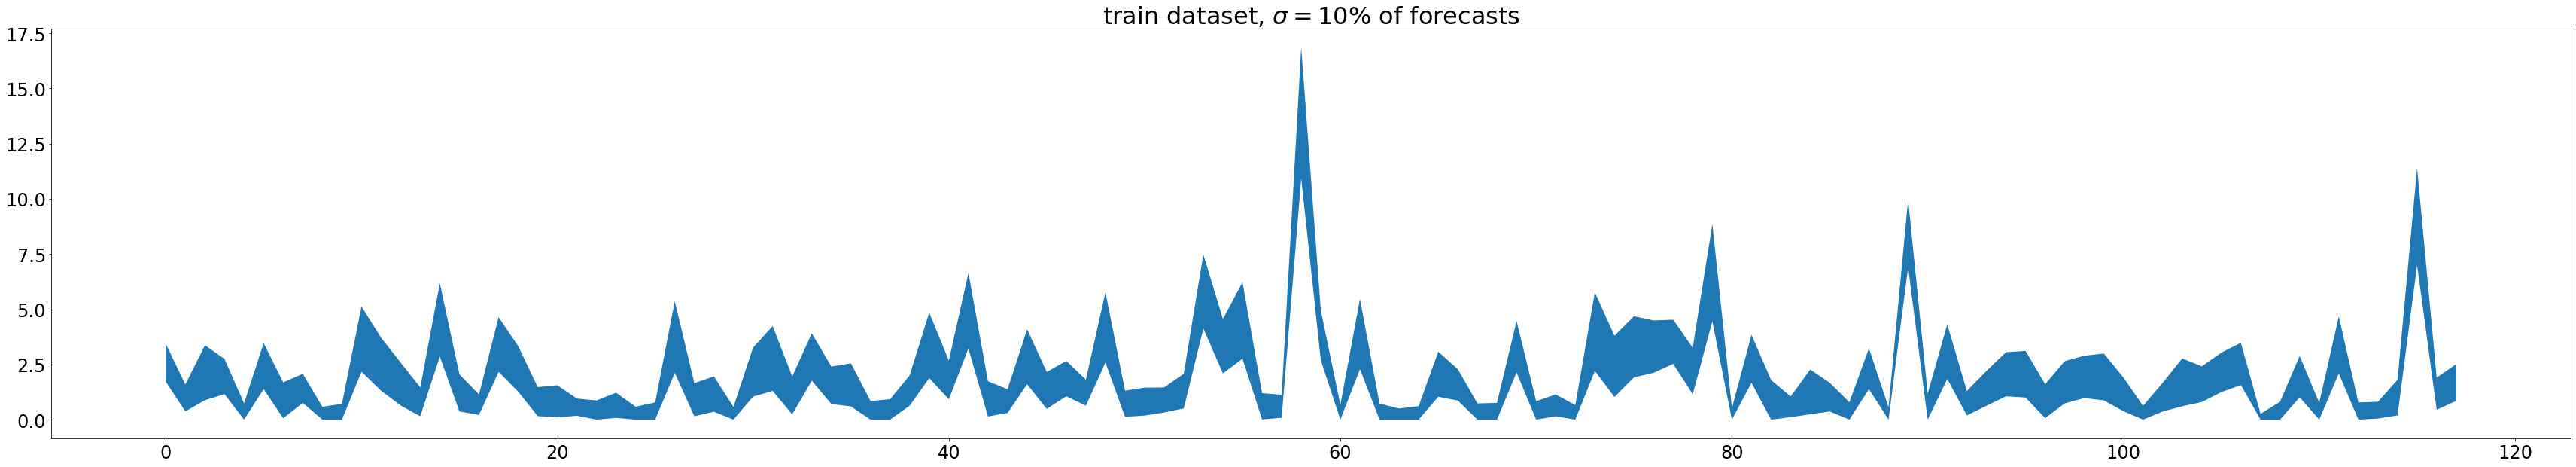

In [253]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(N))
lb = np.min(train_dataset, axis=0)
ub = np.max(train_dataset, axis=0)

ax0.fill_between(Xrange, ub, lb)

ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )
# ax0.set_xlabel('Buses', fontsize=24 )
# ax0.set_ylabel('total power', fontsize=24 )
ax0.set_title(r'train dataset, $\sigma=$'+str(int(input_std*100))+'% of forecasts', fontsize=32, color='k' )
plt.show()

## Define feasibility set $\mathcal{P}^{\text{rs}}$ and $\mathcal{P}^{\text{rc}}$.
Note that rs means reserve, i.e., the first stage, and rc means recourse, i.e., the second stage.


*   $\mathcal{P}^{\text{rs}}=\{u:=[x,\bar{r},\underline{r}]: G^{\text{rs}}u\leq h(\bar{l})^{\text{rs}}\}$
*   $\mathcal{P}^{\text{rc}}=\{\theta^{\omega}: G^{\text{rc}}\theta^{\omega}\leq h(\bar{l}+\omega)^{\text{rc}}\}$



In [ ]:
ones = np.ones((N, 1))
zeros = np.zeros((N, 1))
ZerosN = np.zeros((N, N))
I_N = np.eye(N)

G_rs = np.block([
              [-ones.T, zeros.T, zeros.T],
              [I_N, I_N, ZerosN],
              [-I_N, ZerosN, I_N],
              [ZerosN, -I_N, ZerosN],
              [ZerosN, ZerosN, -I_N],
              [I_N, ZerosN, ZerosN],
              [-I_N, ZerosN, ZerosN]
])
assert G_rs.shape[0] == int(1+6*N)
assert G_rs.shape[1] == int(3*N)


G_rc = np.block([
              [Arr],
              [-Arr],
              [np.eye(N-1)],
              [-np.eye(N-1)],
              [-Yrr],
              [Yrr]
])
assert G_rc.shape[0] == int(2*L+2*(N-1)+2*N)
assert G_rc.shape[1] == int(N-1)


## Find analytical center of polytope

In [303]:
def get_hrs(Sd):

    h_rs = np.block([
                [-Sd],
                [Pmax*np.ones((N,1))],
                [-Pmin*np.ones((N,1))],
                [np.zeros((N,1))],
                [np.zeros((N,1))],
                [Pmax*np.ones((N,1))],
                [-Pmin*np.ones((N,1))]
    ])

    return h_rs

def get_hrc(D_max, D_min):
    h_rc = np.block([
                  [Fmax*np.ones((L,1))],
                  [Fmax*np.ones((L,1))],
                  [np.pi*np.ones((N-1,1))],
                  [np.pi*np.ones((N-1,1))],
                  [(D_min)-Pmin*np.ones((N,1))],
                  [Pmax*np.ones((N,1))-(D_max)]
    ])

    return h_rc


In [ ]:
def get_Cheby_center(A, b):

    # A = np.concatenate([A[:1,:], A[-N-N:-N,:], A[-N:,:]], axis=0)
    # b = np.concatenate([b[:1,:], b[-N-N:-N,:], b[-N:,:]], axis=0)

    m = A.shape[0]
    n = A.shape[1]
    a = np.linalg.norm(A, axis=-1).reshape(-1,1)

    r = cp.Variable()
    x_cheb = cp.Variable((n,1))

    
    constraints_list = []

    constraints_list.append( A@x_cheb + r*a<=b)

    prob = cp.Problem(cp.Maximize(r), constraints_list)

    # prob.solve(verbose = False, solver = cp.CVXOPT) ## Works!
    prob.solve(verbose = False, solver = cp.SCS) ## Works!

    assert prob.status not in ["infeasible", "unbounded"], print('This problem is '+prob.status+'.')

    return x_cheb.value, r.value


## Find strictly feasible point for feasibility set $\mathcal{P}^{\text{rs}}$

In [330]:
max_Sd_tr = np.max(np.sum(train_dataset, axis=-1))
max_forecast_tr = np.max(train_dataset, axis=0).reshape(-1,1)

print('max_Sd_tr:', max_Sd_tr)
print('max_forecast_tr:', max_forecast_tr.shape)

# estimate the maximum possible value of \bar{l}
Sd = max_Sd_tr*1.05

h_rs = get_hrs(Sd)
u_cheby, _ = get_Cheby_center(G_rs, h_rs)

h_cheby = G_rs@u_cheby

print(h_cheby[0,0])
print(h_rs[0,0])

max_Sd_tr: 227.31187038694725
max_forecast_tr: (118, 1)
-1180.942729304041
-238.67746390629463


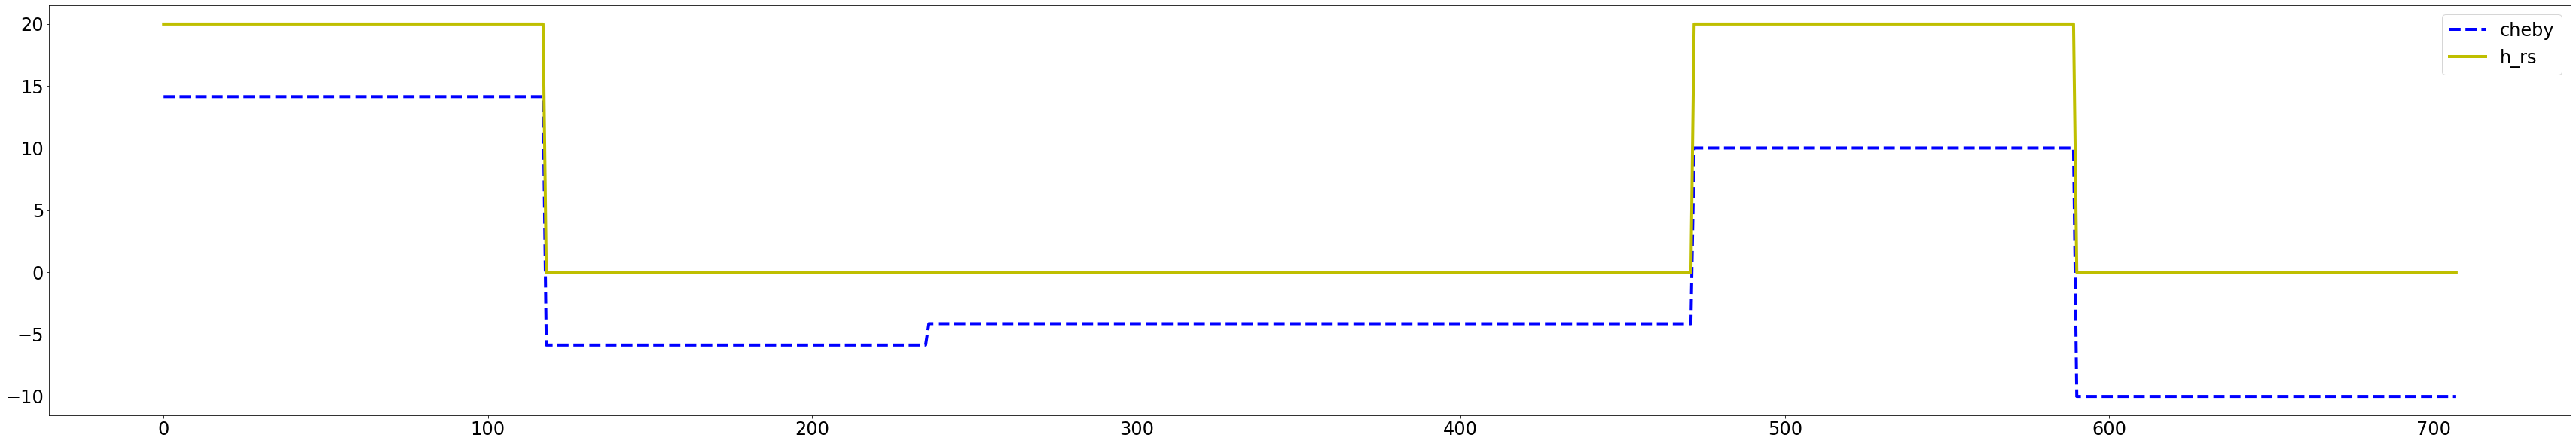

In [331]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(h_rs.shape[0]-1))


ax0.plot(Xrange, h_cheby[1:,0], 'b--', markersize=10, linewidth=4, label='cheby')
ax0.plot(Xrange, h_rs[1:,0], 'y-', markersize=10, linewidth=4, label='h_rs')

ax0.legend(fontsize=24, loc='best')
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )

plt.show()

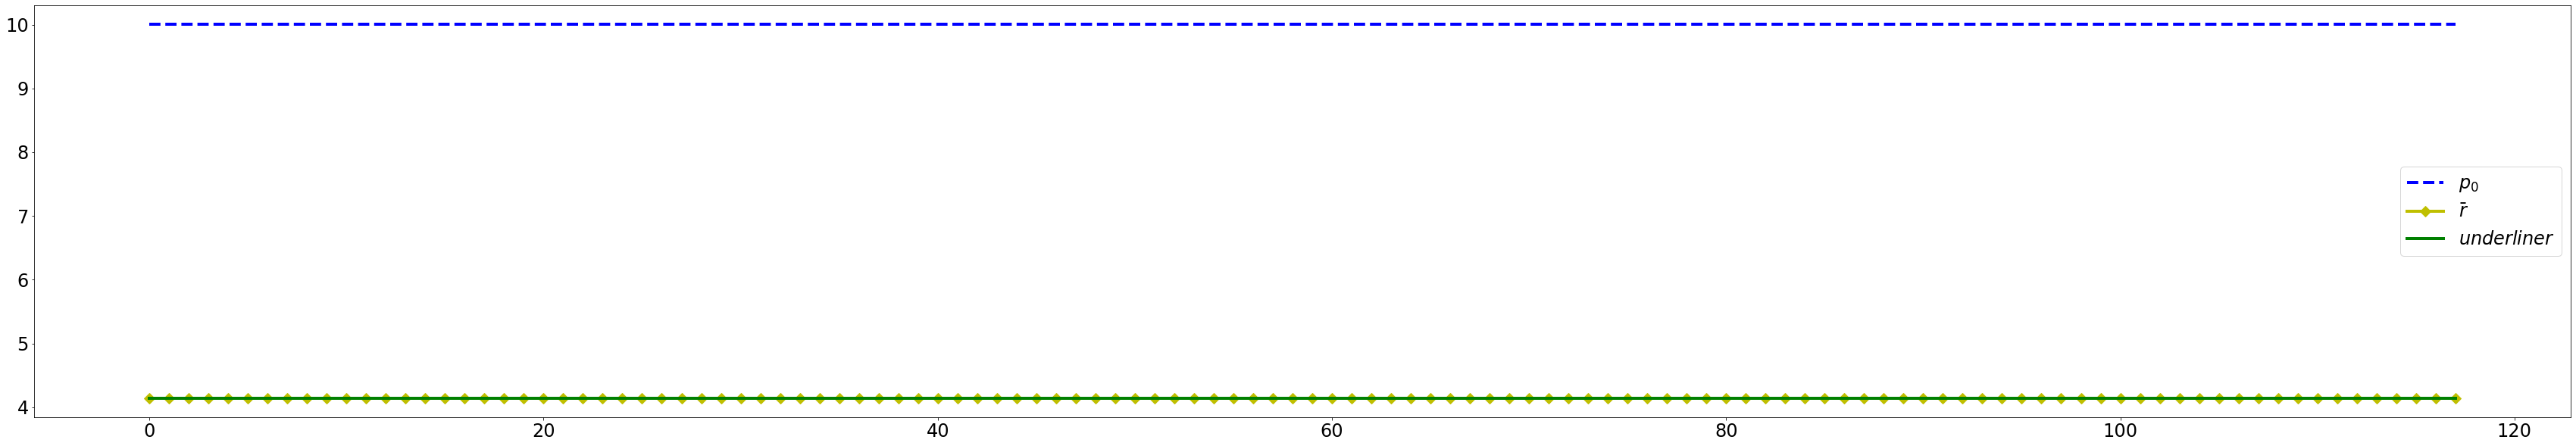

In [332]:
p0 = u_cheby[:N,:]
r_up = u_cheby[N:N+N,:]
r_down = u_cheby[N+N:,:]

fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(N))


ax0.plot(Xrange, p0[:,0], 'b--', markersize=10, linewidth=4, label= r'$p_0$')
ax0.plot(Xrange, r_up[:,0], 'y-D', markersize=10, linewidth=4, label= r'$\bar{r}$')
ax0.plot(Xrange, r_down[:,0], 'g-', markersize=10, linewidth=4, label= r'$underline{r}$')

ax0.legend(fontsize=24, loc='best')
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )

plt.show()

In [333]:
# A trivial one
delta = 0.5
# p0 = max_forecast_tr + 2*delta
p0 = np.ones((N,1))*max_Sd_tr/N + 2*delta
r_up = np.ones((N,1))*delta
r_down = np.ones((N,1))*delta
u_trivial = np.concatenate([p0, r_up, r_down], axis=0)
print(u_trivial.shape)

h_trivial = G_rs@u_trivial

print(h_trivial[0,0])
print(h_rs[0,0])

(354, 1)
-345.31187038694736
-238.67746390629463


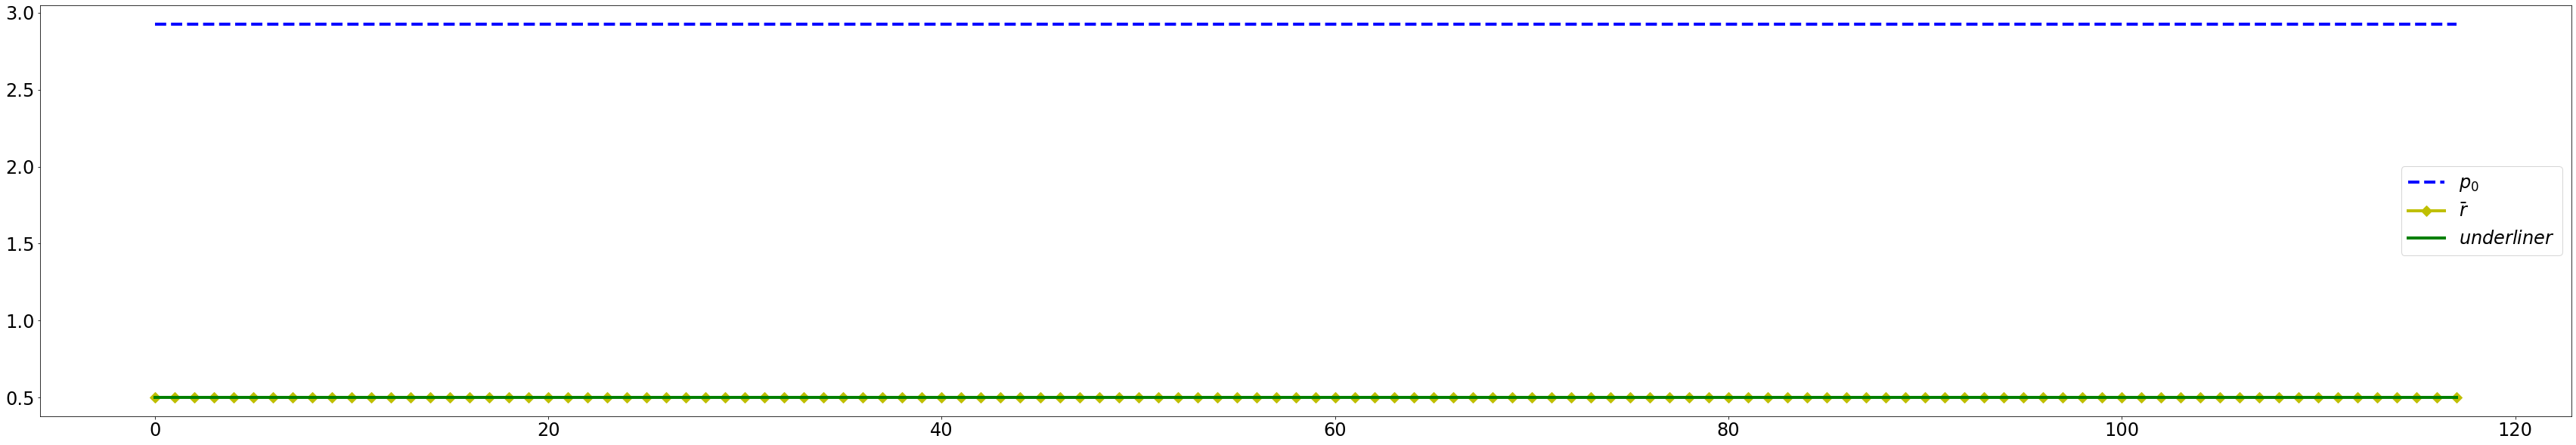

In [334]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(N))


ax0.plot(Xrange, p0[:,0], 'b--', markersize=10, linewidth=4, label= r'$p_0$')
ax0.plot(Xrange, r_up[:,0], 'y-D', markersize=10, linewidth=4, label= r'$\bar{r}$')
ax0.plot(Xrange, r_down[:,0], 'g-', markersize=10, linewidth=4, label= r'$underline{r}$')

ax0.legend(fontsize=24, loc='best')
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )

plt.show()

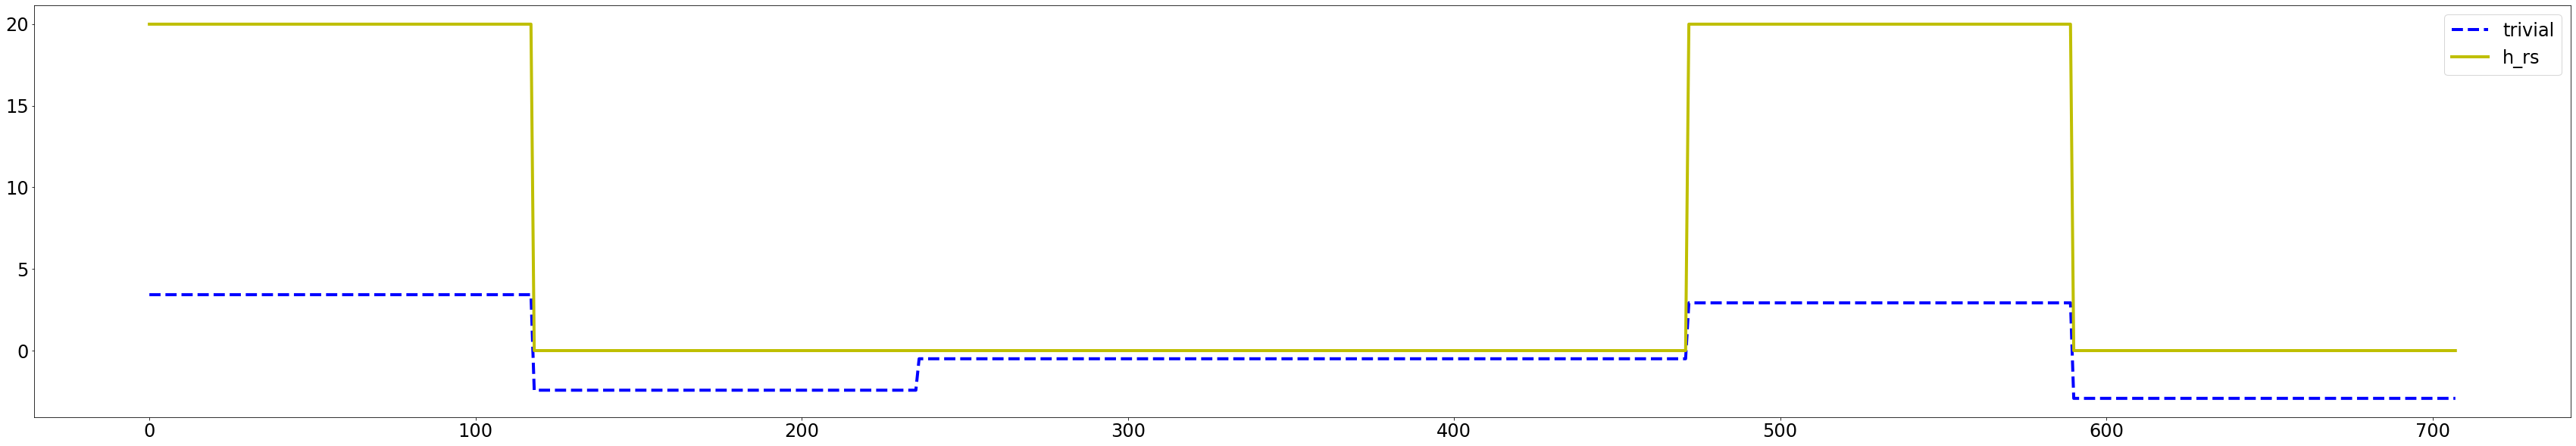

In [335]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(h_rs.shape[0]-1))


ax0.plot(Xrange, h_trivial[1:,0], 'b--', markersize=10, linewidth=4, label='trivial')
ax0.plot(Xrange, h_rs[1:,0], 'y-', markersize=10, linewidth=4, label='h_rs')

ax0.legend(fontsize=24, loc='best')
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )

plt.show()

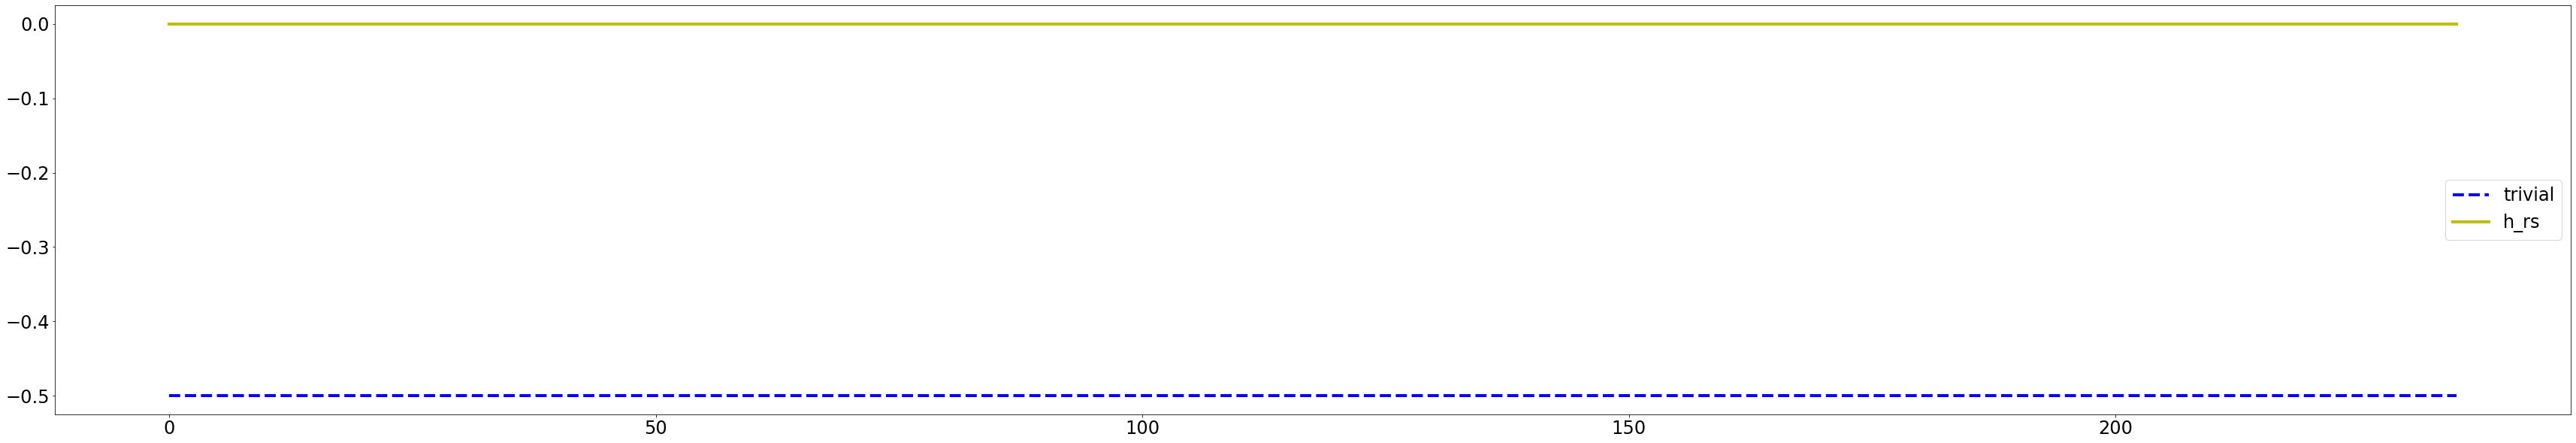

In [336]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(N+N))


ax0.plot(Xrange, h_trivial[1+N+N:1+N+N+N+N,0], 'b--', markersize=10, linewidth=4, label='trivial')
ax0.plot(Xrange, h_rs[1+N+N:1+N+N+N+N,0], 'y-', markersize=10, linewidth=4, label='h_rs')

ax0.legend(fontsize=24, loc='best')
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )

plt.show()

## Find strictly feasible point for feasibility set $\mathcal{P}^{\text{rc}}$

In [337]:
# have to estimate the possible largest value of forecast+omega
# and make sure B\theta > this value-Pmax
min_forecast_tr = np.min(train_dataset, axis=0).reshape(-1,1)

D_max = max_forecast_tr + max_forecast_tr*sce_std*4 
D_min = min_forecast_tr - min_forecast_tr*sce_std*4

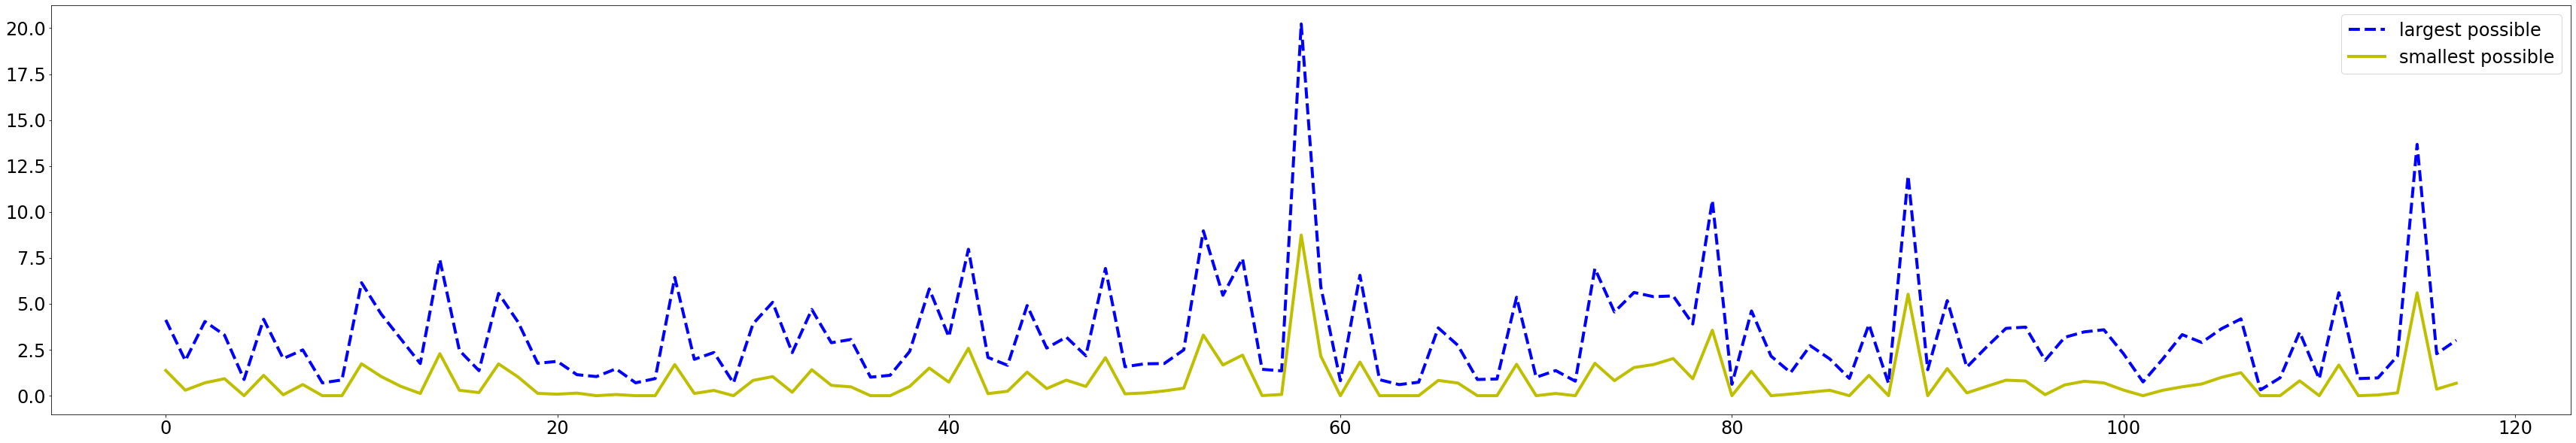

In [339]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(N))


ax0.plot(Xrange, D_max[:,0], 'b--', markersize=10, linewidth=4, label='largest possible')
ax0.plot(Xrange, D_min[:,0], 'y-', markersize=10, linewidth=4, label='smallest possible')

ax0.legend(fontsize=24, loc='best')
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )

plt.show()

In [340]:
h_rc = get_hrc(D_max, D_min)
theta_cheby, _ = get_Cheby_center(G_rc, h_rc)

h_cheby = G_rc@theta_cheby

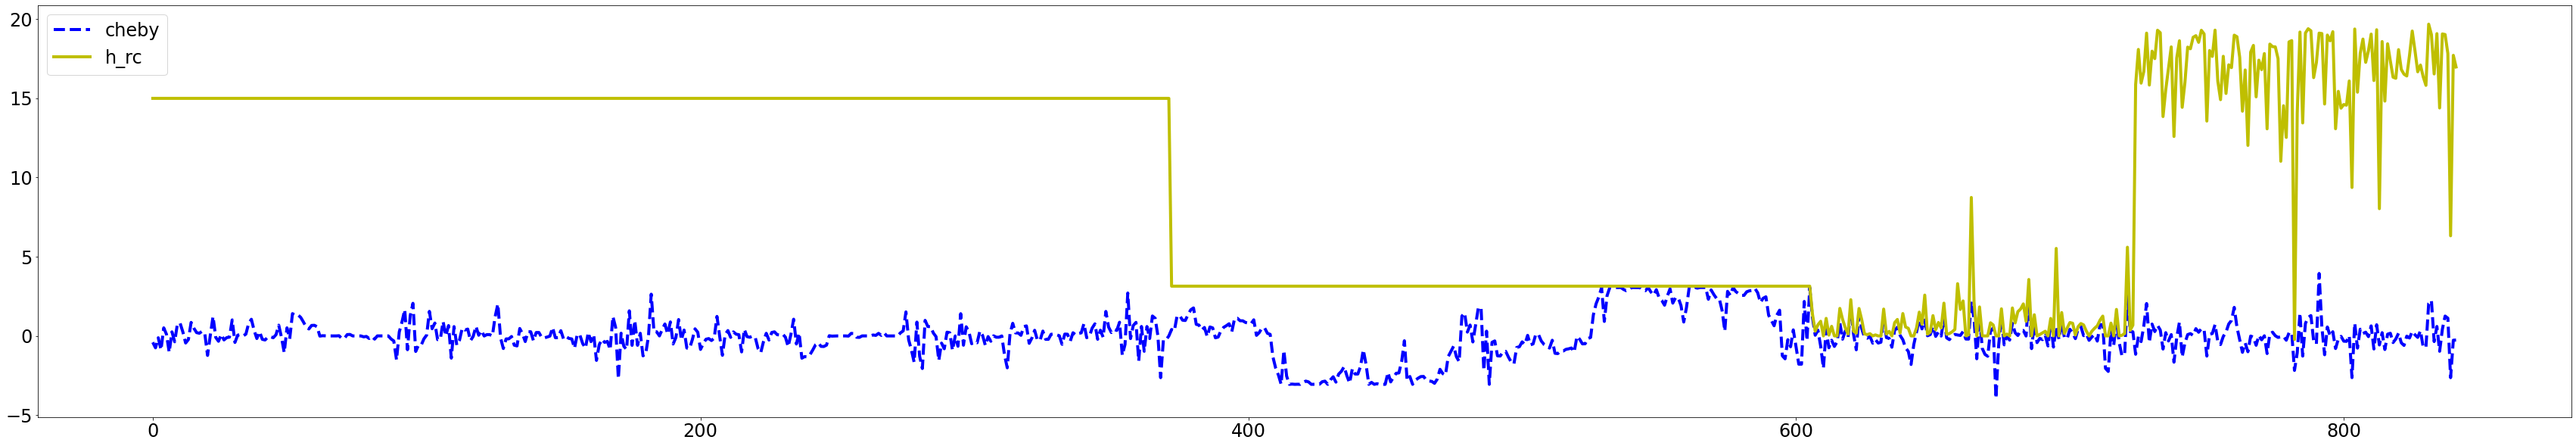

In [342]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(h_cheby.shape[0]))


ax0.plot(Xrange, h_cheby[:,0], 'b--', markersize=10, linewidth=4, label='cheby')
ax0.plot(Xrange, h_rc[:,0], 'y-', markersize=10, linewidth=4, label='h_rc')

ax0.legend(fontsize=24, loc='best')
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )

plt.show()

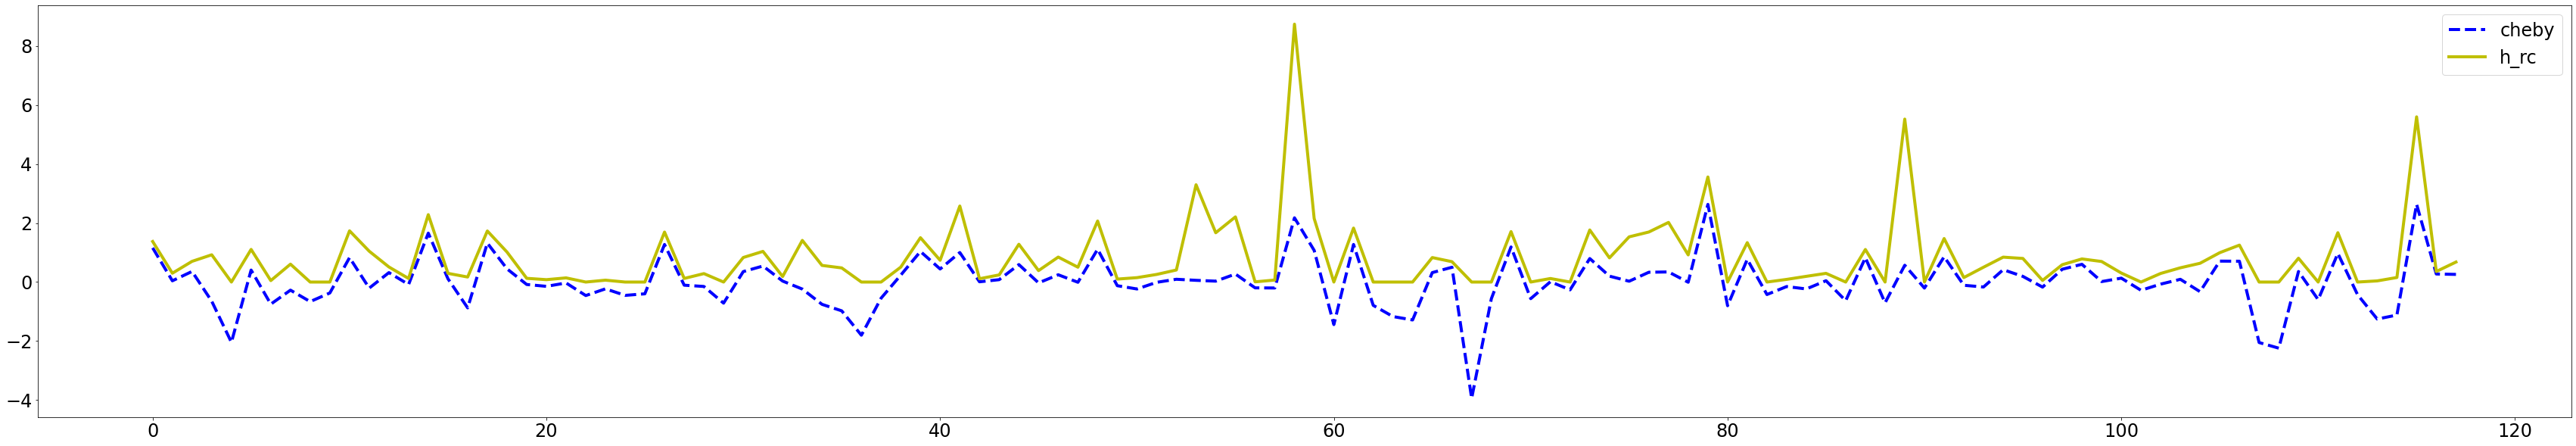

In [343]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(N))


ax0.plot(Xrange, h_cheby[-N-N:-N,0], 'b--', markersize=10, linewidth=4, label='cheby')
ax0.plot(Xrange, h_rc[-N-N:-N,0], 'y-', markersize=10, linewidth=4, label='h_rc')

ax0.legend(fontsize=24, loc='best')
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )

plt.show()

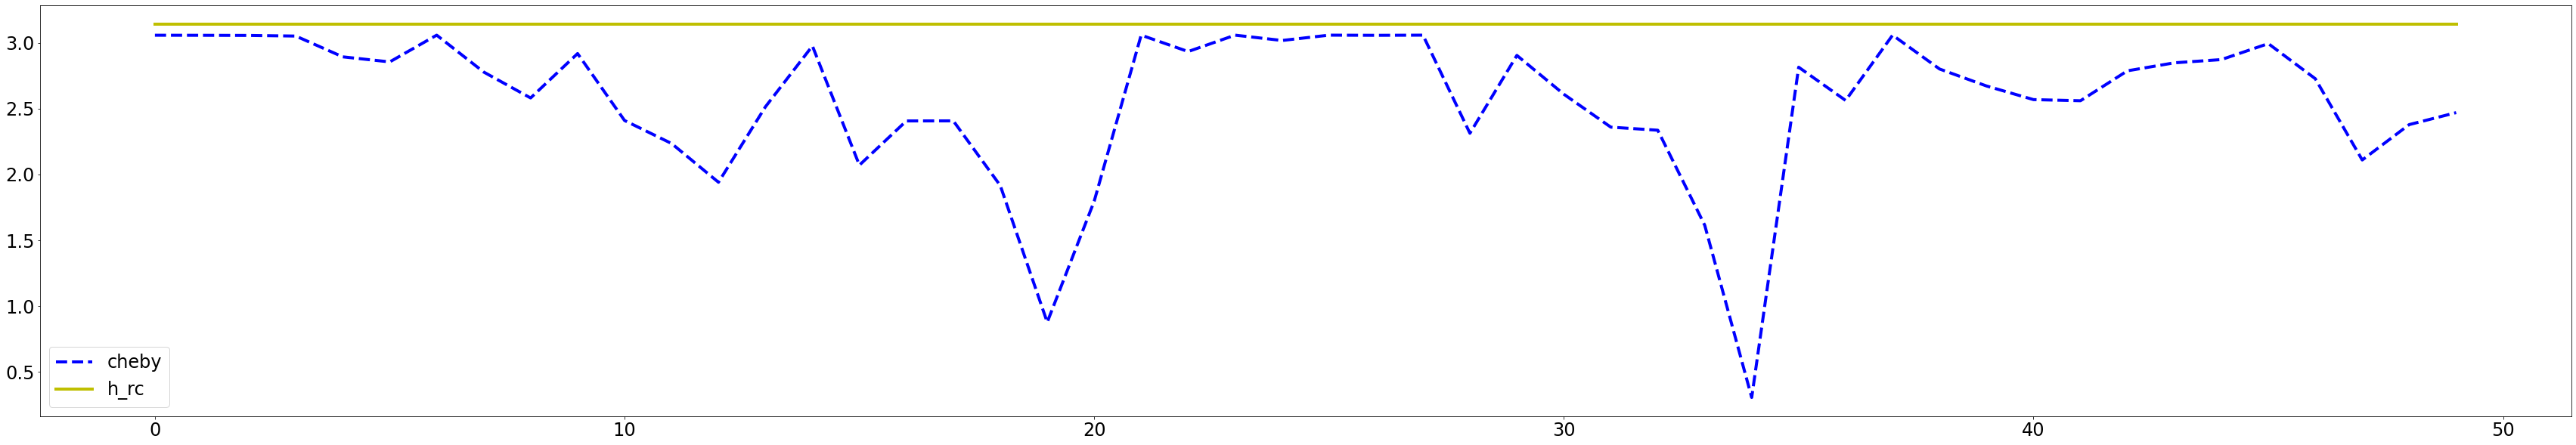

In [344]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(50))


ax0.plot(Xrange, h_cheby[540:590,0], 'b--', markersize=10, linewidth=4, label='cheby')
ax0.plot(Xrange, h_rc[540:590,0], 'y-', markersize=10, linewidth=4, label='h_rc')

ax0.legend(fontsize=24, loc='best')
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )

plt.show()

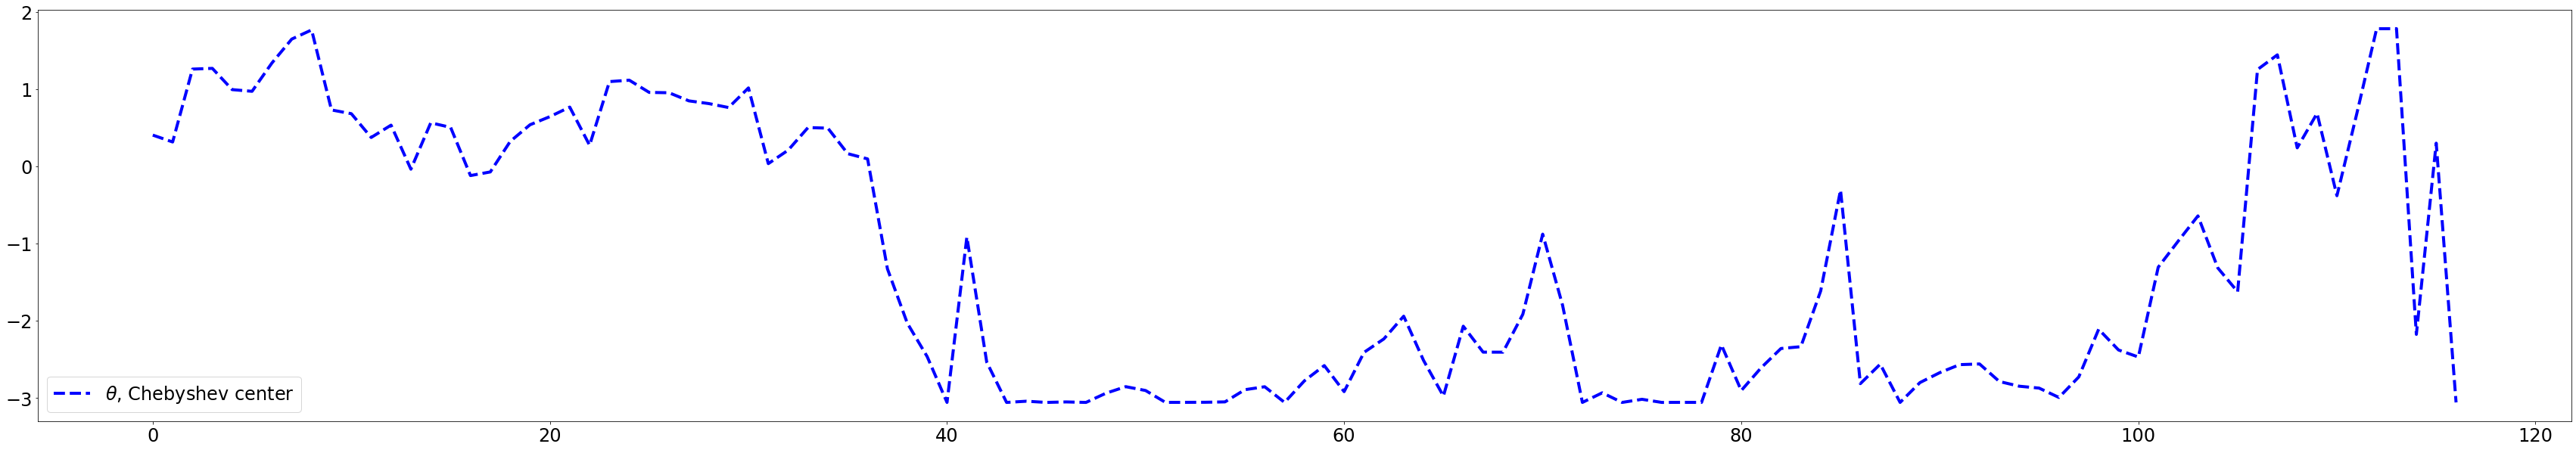

In [345]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(N-1))


ax0.plot(Xrange, theta_cheby[:,0], 'b--', markersize=10, linewidth=4, label=r'$\theta$, Chebyshev center')

ax0.legend(fontsize=24, loc='best')
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )

plt.show()

In [346]:
np.min(theta_cheby)

-3.057782172705268

In [347]:
np.max(theta_cheby)

1.7839057188516383

## Construct dataset for pretrain


*   X_train, X_test for action net training
*   X_train2, X_test2 for reward net training


### Format:

*   X_train, X_test: [forecasts, x_true]
*   X_train2, X_test2:[forecasts-x_true, theta_true, y_true, Q_true]


In [ ]:
np.save(data_path+'u_cheby.npy', u_cheby)
np.save(data_path+'u_trivial.npy', u_trivial)
np.save(data_path+'theta_cheby.npy', theta_cheby)

In [254]:
N_gap = 2
N_m_gap = 2
N_ap = 2
N_cp = 2
N_eval = 2

In [255]:
# pretrain_dataset = pretrain_dataset[:1,:]
# x_true, _, cp_times = solver_outer_loop(pretrain_dataset, num_sce=N_cp, solver_name='saa')
# X_tr = np.concatenate([pretrain_dataset, x_true], axis=-1)/np.max(pretrain_dataset)
# # X_train = X_tr[:int(Ntr2*0.9),:]
# # X_test = X_tr[int(Ntr2*0.9):,:]

In [256]:
# print(np.sum(cp_times))

In [257]:
# np.save(data_path+'X_train.npy', X_train)
# np.save(data_path+'X_test.npy', X_test)

In [258]:
# Q_omega, y_omega, theta_omega, net_d_omega = solve_stochastic_dcopf(pretrain_dataset, x_true)
# X_tr2 = np.concatenate([net_d_omega, theta_omega, y_omega, Q_omega], axis=-1)
# # X_train2 = X_tr2[:int(Ntr2*0.9),:]
# # X_test2 = X_tr2[int(Ntr2*0.9):,:]

In [259]:
# np.save(data_path+'X_train2.npy', X_train2)
# np.save(data_path+'X_test2.npy', X_test2)

# visualize.py

In [42]:
p0 = x_true[:,:N]
r_up = x_true[:,N:N+N]
r_down = x_true[:,N+N:]

realizations = net_d_omega + p0
z_actual = p0+y_omega
total_cost = p0@c + (r_up+r_down)@c*DayAheadReserveCostFactor + Q_omega
print('z_actual:', z_actual.shape)

z_actual: (10, 118)


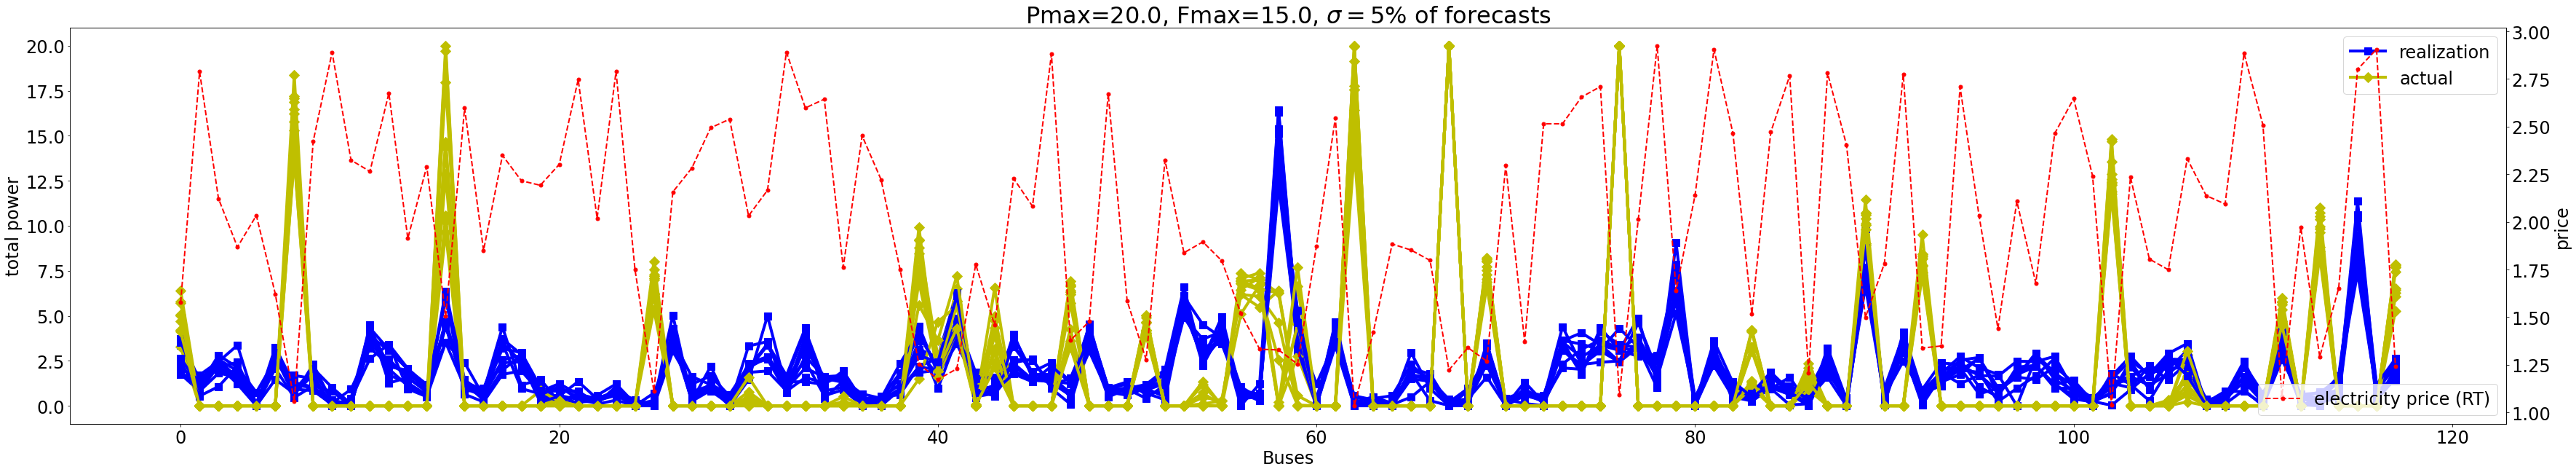

In [43]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(N))
N_points = Ntr2
for i in range(N_points):
    if i == 0:
        ax0.plot(Xrange, realizations[i,:], 'b-s', markersize=10, linewidth=4, label='realization')
        ax0.plot(Xrange, z_actual[i,:], 'y-D', markersize=10, linewidth=4, label='actual')
    else:
        ax0.plot(Xrange, realizations[i,:], 'b-s', markersize=10, linewidth=4)
        ax0.plot(Xrange, z_actual[i,:], 'y-D', markersize=10, linewidth=4)

# ax0.axhline(y=Pmax, xmin=0.0, xmax=1.0, color='k', linestyle='--', linewidth=1, label='Pmax')
ax0.legend(fontsize=24, loc='best')
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )
ax0.set_xlabel('Buses', fontsize=24 )
ax0.set_ylabel('total power', fontsize=24 )
ax0.set_title(r'Pmax='+str(Pmax)+', Fmax='+str(Fmax)+', $\sigma=$'+str(int(sce_std*100))+'% of forecasts', 
              fontsize=32, color='k')

ax1 = ax0.twinx()
ax1.plot(range(N), c, 'r--o', markersize=5, linewidth=2, label='electricity price (RT)')
ax1.tick_params(axis='y', labelsize=24 )
ax1.set_ylabel('price', fontsize=24, rotation=90 )
ax1.legend(fontsize=24, loc='lower right')


plt.show()

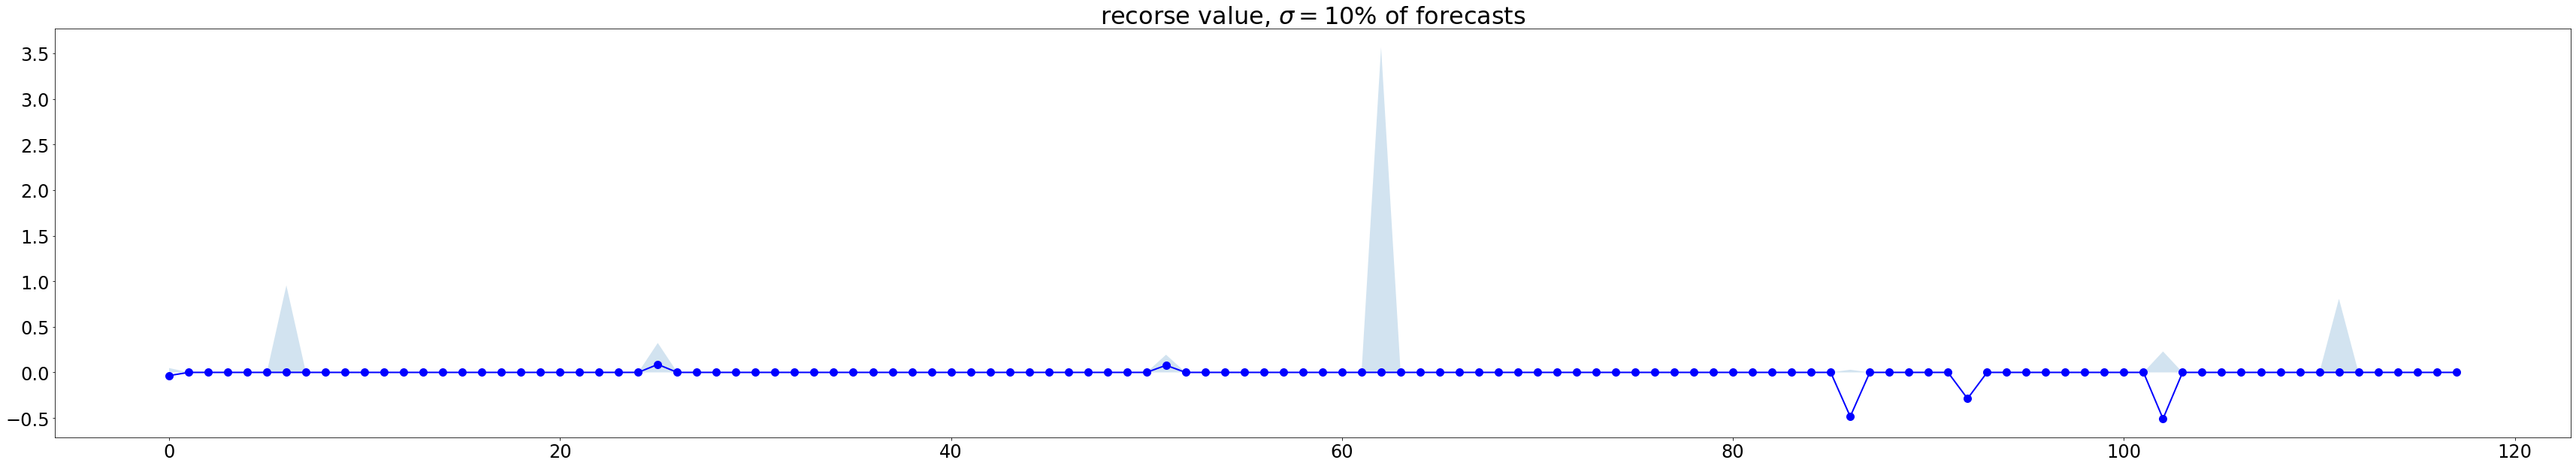

In [44]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(N))

i = 9

lb = r_up[i,:]
ub = -r_down[i,:]

ax0.fill_between(Xrange, ub, lb, alpha=0.2, label='reserve')
ax0.plot(Xrange, y_omega[i,:], 'b-o', markersize=10, linewidth=2, label='recourse')

ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )
# ax0.set_xlabel('Buses', fontsize=24 )
# ax0.set_ylabel('total power', fontsize=24 )
ax0.set_title(r'recorse value, $\sigma=$'+str(int(input_std*100))+'% of forecasts', fontsize=32, color='k' )
plt.show()


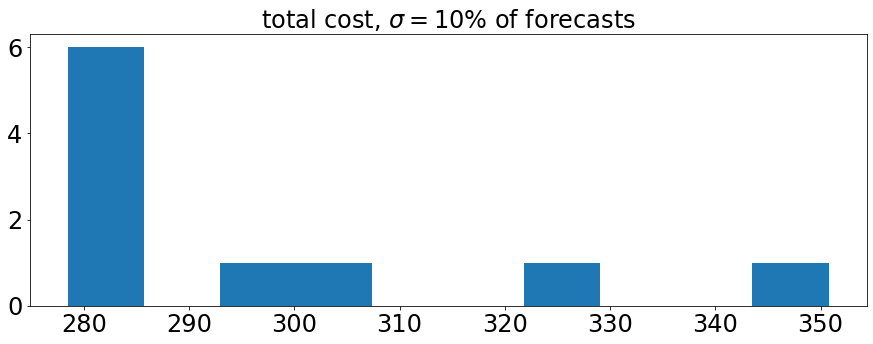

In [55]:
fig, ax0 = plt.subplots(figsize=(15,5))
Xrange = np.array(range(N))

n_bins = 20
data = total_cost.flatten()

counts, bins = np.histogram(data)
ax0.hist(bins[:-1], bins, weights=counts)

ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )
# ax0.set_xlabel('Buses', fontsize=24 )
# ax0.set_ylabel('total power', fontsize=24 )
ax0.set_title(r'total cost, $\sigma=$'+str(int(input_std*100))+'% of forecasts', fontsize=24, color='k' )
plt.show()


# benchmarks.py

## Benchmark1: use cvxpy to solve saa version of the true problem

In [ ]:
# x_cp, _, cp_times = solver_outer_loop(test_dataset, num_sce=N_cp, solver_name='saa')
# np.save(data_path+'x_cp.npy', x_cp)
# np.save(data_path+'cp_times.npy', cp_times)

/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1338: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


In [ ]:
# # # # Evaluate using evaluate_outer_loop(forecasts, x_pred)
# total_cost_cp, Q_cp, y_cp = evaluate_outer_loop(test_dataset, x_cp, num_sce=N_eval)

# np.save(data_path+'total_cost_cp.npy', total_cost_cp)
# np.save(data_path+'Q_cp.npy', Q_cp)
# np.save(data_path+'y_cp.npy', y_cp)

In [ ]:
x_cp = np.load(data_path+'x_cp.npy')
total_cost_cp = np.load(data_path+'total_cost_cp.npy')
Q_cp = np.load(data_path+'Q_cp.npy')
y_cp = np.load(data_path+'y_cp.npy')

## Benchmark2: apply affine policy to $y$ but optimize $\theta$

In [ ]:
# x_hb, _, hb_times = solver_outer_loop(test_dataset, num_sce=N_hb, solver_name='hybrid')
# # np.save(data_path+'x_hb.npy', x_hb)
# # np.save(data_path+'hb_times.npy', hb_times)

In [ ]:
# # # Evaluate using evaluate_outer_loop(forecasts, x_pred)
# total_cost_hb, Q_hb, y_hb = evaluate_outer_loop(test_dataset, x_hb, num_sce=N_eval)

# # np.save(data_path+'total_cost_hb.npy', total_cost_hb)
# # np.save(data_path+'Q_hb.npy', Q_hb)
# # np.save(data_path+'y_hb.npy', y_hb)

## Benchmark3: apply affine policy to $y$ and use $y$ to eliminate $\theta$

In [ ]:
x_gap, _, gap_times = solver_outer_loop(test_dataset, num_sce=N_gap, solver_name='gap', use_elimination=True)

In [ ]:
np.save(data_path+'x_gap.npy', x_gap)
np.save(data_path+'gap_times.npy', gap_times)

In [ ]:
# Evaluate using evaluate_outer_loop(forecasts, x_pred)
total_cost_gap, Q_gap, y_gap = evaluate_outer_loop(test_dataset, x_gap, num_sce=N_eval)

In [ ]:
np.save(data_path+'total_cost_gap.npy', total_cost_gap)
np.save(data_path+'Q_gap.npy', Q_gap)
np.save(data_path+'y_gap.npy', y_gap)

# eval.py

In [ ]:
_, x_dist2 = measure_relative_distance(x_cp, x_gap)
total_cost_dist2_vec, total_cost_dist2 = measure_relative_distance(total_cost_cp, total_cost_gap)
_, Q_dist2 = measure_relative_distance(Q_cp, Q_gap)
_, y_dist2 = measure_relative_distance(y_cp, y_gap)

print('Averaged relative error in x is %.2f%%' % (x_dist2*100))
print('Averaged relative error in J is %.2f%%' % (total_cost_dist2*100))
print('Averaged relative error in Q is %.2f%%' % (Q_dist2*100))
print('Averaged relative error in y is %.2f%%' % (y_dist2*100))

Averaged relative error in x is 9.65%
Averaged relative error in J is 4.80%
Averaged relative error in Q is 55.44%
Averaged relative error in y is 157.49%


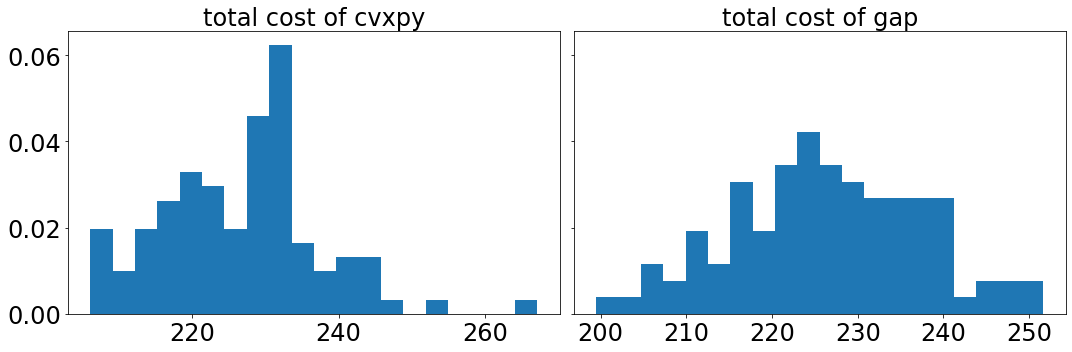

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True,tight_layout=True, figsize=(15,5))

n_bins = 20
axs[0].hist(total_cost_cp.flatten(), bins=n_bins, density=True)

axs[0].tick_params(axis='x', labelsize=24 )
axs[0].tick_params(axis='y', labelsize=24 )
# ax0.set_xlabel('Buses', fontsize=24 )
# ax0.set_ylabel('total power', fontsize=24 )
axs[0].set_title(r'total cost of cvxpy', fontsize=24, color='k' )

axs[1].hist(total_cost_gap.flatten(), bins=n_bins, density=True)
axs[1].tick_params(axis='x', labelsize=24 )
axs[1].set_title(r'total cost of gap', fontsize=24, color='k' )
plt.show()



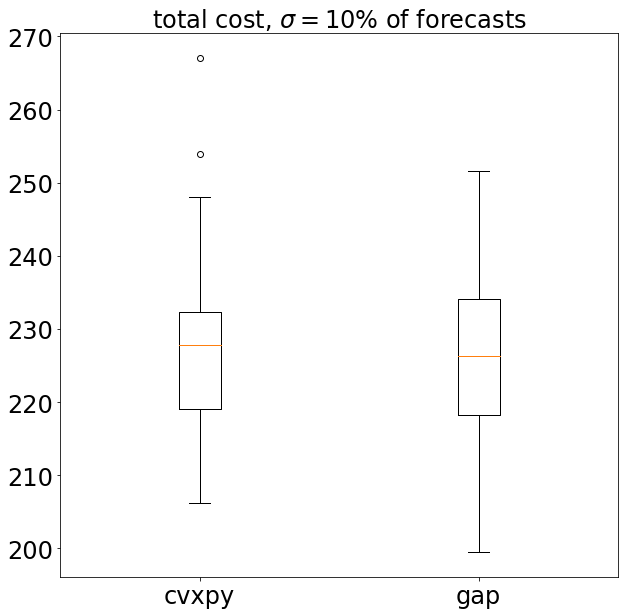

In [ ]:
fig, ax0 = plt.subplots(figsize=(10,10))
Xrange = np.array(range(N))

n_bins = 20

data = [total_cost_cp.flatten(), total_cost_gap.flatten()]
ax0.boxplot(data)

ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )
# ax0.set_xlabel('Buses', fontsize=24 )
# ax0.set_ylabel('total power', fontsize=24 )
ax0.set_xticklabels(['cvxpy', 'gap'])

ax0.set_title(r'total cost, $\sigma=$'+str(int(input_std*100))+'% of forecasts', fontsize=24, color='k' )
plt.show()
